In [35]:
import rasterio
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

Find All TIF Files

In [36]:
tif_files = list(Path('../data/viirs_data/NJ').glob('*.tif')) + \
            list(Path('../data/viirs_data/VT').glob('*.tif'))
print(f"Found {len(tif_files)} TIF files")

Found 1636 TIF files


Check Band Availability Across All Files

In [37]:
summary = []
for tif_path in tif_files:
    with rasterio.open(tif_path) as src:
        filename = tif_path.stem
        state, date = filename.split('_')
        
        # Relevant bands: 2, 3, 5, 6, 7
        band1 = src.read(1) # DNB_BRDF_Corrected_NTL (with gaps)
        band2 = src.read(2) # Gap_Filled_DNB_BRDF_Corrected_NTL
        band3 = src.read(3) # DNB_Lunar_Irradiance
        band4 = src.read(4) # Latest_High_Quality_Retrieval
        band5 = src.read(5) # Mandatory_Quality_Flag
        band6 = src.read(6) # Snow_Flag
        band7 = src.read(7) # QF_Cloud_Mask (bitmask)
        
        high_quality_pixels = (band5 == 0).sum()
        ephemeral_lights = (band5 == 1).sum()
        poor_quality_pixels = (band5 == 2).sum()
        total_valid_pixels = (band5 < 255).sum()

        cloud_bits = (band7.astype(np.uint16) >> 6) & 0b11
        confident_clear = (cloud_bits == 0).sum()
        probably_clear = (cloud_bits == 1).sum()
        probably_cloudy = (cloud_bits == 2).sum()
        confident_cloudy = (cloud_bits == 3).sum()

        snow_coverage = (band6 == 1).mean()

        summary.append({
            'date': date,
            'state': state,

            # Primary light data (Band 2 - gap filled)
            'light_mean': band2.mean(),
            'light_median': np.median(band2),
            'light_max': band2.max(),
            'light_std': band2.std(),
            # Quality assessment (Band 5)
            'quality_high_pct': high_quality_pixels / total_valid_pixels if total_valid_pixels > 0 else 0,
            'quality_ephemeral_pct': ephemeral_lights / total_valid_pixels if total_valid_pixels > 0 else 0,
            'quality_poor_pct': poor_quality_pixels / total_valid_pixels if total_valid_pixels > 0 else 0,
            # Cloud conditions (Band 7)
            'cloud_clear_pct': (confident_clear + probably_clear) / band7.size,
            'cloud_cloudy_pct': (confident_cloudy + probably_cloudy) / band7.size,
            # Environmental factors
            'snow_coverage_pct': snow_coverage,
            'lunar_irradiance_mean': band3.mean(),
            # Data completeness
            'has_gaps': (band1 == 0).mean() > (band2 == 0).mean(),
            'gap_fill_effectiveness': ((band1 == 0).sum() - (band2 == 0).sum()) / band1.size,
        })

df_summary = pd.DataFrame(summary)

Output Summary Statistics

In [38]:
print("~~~~~ DATA AVAILABILITY SUMMARY ~~~~~")
print(f"Total files: {len(df_summary)}")

print("\n[Light Pollution Metrics — Band 2: Gap-Filled NTL]")
print(f" - Mean radiance for all files: {df_summary['light_mean'].mean():.4f}")
print(f" - Median brightness for all files: {df_summary['light_median'].mean():.4f}")
print(f" - Max radiance observed: {df_summary['light_max'].max():.4f}")

print("\n[Data Quality — Band 5: Mandatory Quality Flag]")
print(f" - Average High-quality pixels: {df_summary['quality_high_pct'].mean()*100:.1f}%")
print(f" - Average ephemeral light pixels: {df_summary['quality_ephemeral_pct'].mean()*100:.1f}%")
print(f" - Average low-quality pixels: {df_summary['quality_poor_pct'].mean()*100:.1f}%")

print("\n[Cloud Conditions — Band 7: Cloud Mask]")
print(f" - Average clear conditions: {df_summary['cloud_clear_pct'].mean()*100:.1f}%")
print(f" - Average cloudy conditions: {df_summary['cloud_cloudy_pct'].mean()*100:.1f}%")

print("\n[Environmental Factors]")
print(f" - Average snow coverage: {df_summary['snow_coverage_pct'].mean()*100:.1f}%")
print(f" - Average lunar irradiance: {df_summary['lunar_irradiance_mean'].mean():.4f}")

print("\n[Gap-Filling Effectiveness]")
print(f" - Files with gaps filled: {df_summary['has_gaps'].sum()} of {len(df_summary)}")
print(f" - Average gap fill rate: {df_summary['gap_fill_effectiveness'].mean()*100:.2f}%")


~~~~~ DATA AVAILABILITY SUMMARY ~~~~~
Total files: 1636

[Light Pollution Metrics — Band 2: Gap-Filled NTL]
 - Mean radiance for all files: 24.8516
 - Median brightness for all files: 24.9317
 - Max radiance observed: 6552.6000

[Data Quality — Band 5: Mandatory Quality Flag]
 - Average High-quality pixels: 95.2%
 - Average ephemeral light pixels: 2.1%
 - Average low-quality pixels: 2.3%

[Cloud Conditions — Band 7: Cloud Mask]
 - Average clear conditions: 100.0%
 - Average cloudy conditions: 0.0%

[Environmental Factors]
 - Average snow coverage: 0.0%
 - Average lunar irradiance: 4.3665

[Gap-Filling Effectiveness]
 - Files with gaps filled: 1609 of 1636
 - Average gap fill rate: 49.81%


Problematic Dates

In [39]:
print("\n~~~~~ FLAGGED DATES FOR REVIEW ~~~~~")
problematic = df_summary[
    (df_summary['cloud_cloudy_pct'] > 0.5) |  # More than 50% cloudy
    (df_summary['quality_poor_pct'] > 0.3) |   # More than 30% poor quality
    (df_summary['snow_coverage_pct'] > 0.2)    # More than 20% snow
].sort_values('cloud_cloudy_pct', ascending=False)

if len(problematic) > 0:
    print(f"\n{len(problematic)} dates flagged for potential issues:")
    print(problematic[['date', 'state', 'cloud_cloudy_pct', 'quality_poor_pct', 'snow_coverage_pct']].head(10))
else:
    print("No problematic dates found!")


~~~~~ FLAGGED DATES FOR REVIEW ~~~~~

41 dates flagged for potential issues:
           date state  cloud_cloudy_pct  quality_poor_pct  snow_coverage_pct
86   2021-05-26    NJ               0.0          0.322760                0.0
97   2021-06-06    NJ               0.0          0.766194                0.0
289  2023-05-27    NJ               0.0          0.771132                0.0
295  2023-06-02    NJ               0.0          0.408009                0.0
299  2023-06-06    NJ               0.0          0.302883                0.0
300  2023-06-07    NJ               0.0          0.833634                0.0
503  2024-05-29    NJ               0.0          0.752759                0.0
509  2024-06-09    NJ               0.0          0.320642                0.0
514  2024-06-14    NJ               0.0          0.617941                0.0
704  2025-05-27    NJ               0.0          0.446743                0.0


Load BirdCast Data

In [40]:
df_nj = pd.read_csv('../data/birdcast/birdcast_peak_data_NJ.csv')
df_vt = pd.read_csv('../data/birdcast/birdcast_peak_data_VT.csv')
df_nj['state'] = 'NJ'
df_vt['state'] = 'VT'
df_birds = pd.concat([df_nj, df_vt])
df_birds['date'] = pd.to_datetime(df_birds['date'])

print(f"\n~~~~~ BIRDCAST DATA ~~~~~")
print(f"Total BirdCast records: {len(df_birds)}")
print(f"Date range: {df_birds['date'].min()} to {df_birds['date'].max()}")
print(f"Total missing values: {df_birds.isnull().sum()}")
print(f"Records with zero migration: {(df_birds['total_passed'] == 0).sum()}")
print(df_birds.head())


~~~~~ BIRDCAST DATA ~~~~~
Total BirdCast records: 1690
Date range: 2021-03-01 00:00:00 to 2025-11-04 00:00:00
Total missing values: date                0
total_passed        0
peak_birds          0
peak_direction      0
peak_speed_mph      0
peak_altitude_ft    0
state               0
dtype: int64
Records with zero migration: 0
        date total_passed peak_birds peak_direction peak_speed_mph  \
0 2021-03-01        10600      21500              —              -   
1 2021-03-02        65700      87900             NE           21.0   
2 2021-03-03        85500      72100             NE           23.0   
3 2021-03-04        10500      24100              —              -   
4 2021-03-05        10700      26000              —              -   

  peak_altitude_ft state  
0                -    NJ  
1            700.0    NJ  
2           1000.0    NJ  
3                -    NJ  
4                -    NJ  


Check Date Overlap

In [41]:
df_summary['date'] = pd.to_datetime(df_summary['date'])

viirs_dates = set(df_summary['date'])
bird_dates = set(df_birds['date'])
overlap_dates = viirs_dates & bird_dates

print(f"\n~~~~~ DATE OVERLAP ~~~~~")
print(f"VIIRS dates: {len(viirs_dates)}")
print(f"BirdCast dates: {len(bird_dates)}")
print(f"Overlapping dates: {len(overlap_dates)}")
print(f"VIIRS-only dates: {len(viirs_dates - bird_dates)}")
print(f"BirdCast-only dates: {len(bird_dates - viirs_dates)}")
print(f"Coverage: {len(overlap_dates)/len(bird_dates)*100:.1f}% of BirdCast dates have VIIRS data")


~~~~~ DATE OVERLAP ~~~~~
VIIRS dates: 818
BirdCast dates: 845
Overlapping dates: 818
VIIRS-only dates: 0
BirdCast-only dates: 27
Coverage: 96.8% of BirdCast dates have VIIRS data


Check data distribution before plotting

In [42]:
for state in ['NJ', 'VT']:
    state_count = (df_summary['state'] == state).sum()
    print(f"{state}: {state_count} observations")
    if state_count > 0:
        state_data = df_summary[df_summary['state'] == state]
        print(f"  Date range: {state_data['date'].min()} to {state_data['date'].max()}")
        print(f"  Cloud clear % range: {state_data['cloud_clear_pct'].min()*100:.1f}% - {state_data['cloud_clear_pct'].max()*100:.1f}%")
        print(f"  Snow coverage % range: {state_data['snow_coverage_pct'].min()*100:.1f}% - {state_data['snow_coverage_pct'].max()*100:.1f}%")

NJ: 818 observations
  Date range: 2021-03-01 00:00:00 to 2025-11-03 00:00:00
  Cloud clear % range: 100.0% - 100.0%
  Snow coverage % range: 0.0% - 0.0%
VT: 818 observations
  Date range: 2021-03-01 00:00:00 to 2025-11-03 00:00:00
  Cloud clear % range: 100.0% - 100.0%
  Snow coverage % range: 0.0% - 0.0%


Visualize Data Availability

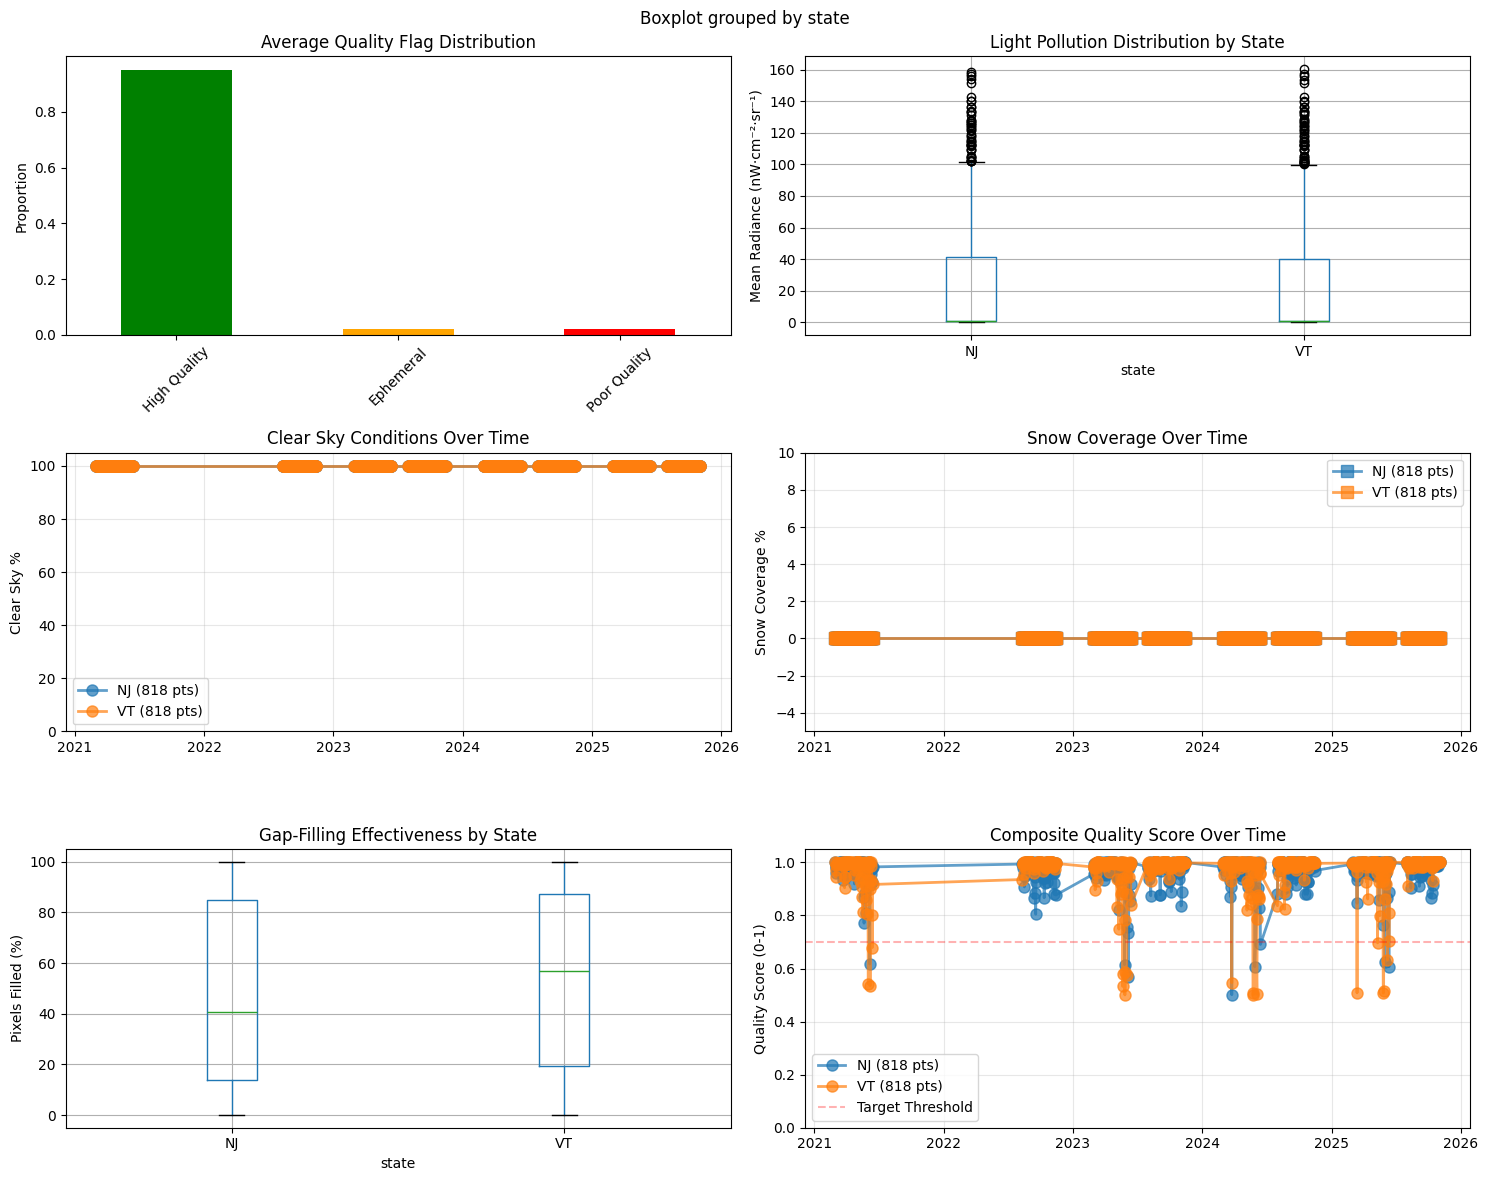

In [44]:
fig, axes = plt.subplots(3, 2, figsize=(15, 12))

# 1. Quality Flag Distribution
quality_cols = ['quality_high_pct', 'quality_ephemeral_pct', 'quality_poor_pct']
df_summary[quality_cols].mean().plot(kind='bar', ax=axes[0,0], 
                                      title='Average Quality Flag Distribution',
                                      color=['green', 'orange', 'red'])
axes[0,0].set_ylabel('Proportion')
axes[0,0].set_xticklabels(['High Quality', 'Ephemeral', 'Poor Quality'], rotation=45)

# 2. Light Pollution by State
df_summary.boxplot(column='light_mean', by='state', ax=axes[0,1])
axes[0,1].set_title('Light Pollution Distribution by State')
axes[0,1].set_ylabel('Mean Radiance (nW·cm⁻²·sr⁻¹)')
plt.sca(axes[0,1])
plt.xticks(rotation=0)

# 3. Cloud Coverage Over Time
for state in ['NJ', 'VT']:
    state_data = df_summary[df_summary['state'] == state].sort_values('date')
    if len(state_data) > 0:
        axes[1,0].plot(state_data['date'], state_data['cloud_clear_pct']*100, 
                       marker='o', markersize=8, label=f'{state} ({len(state_data)} pts)', 
                       alpha=0.7, linewidth=2)
axes[1,0].set_title('Clear Sky Conditions Over Time')
axes[1,0].set_ylabel('Clear Sky %')
axes[1,0].set_ylim(0, 105)
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 4. Snow Coverage Timeline
for state in ['NJ', 'VT']:
    state_data = df_summary[df_summary['state'] == state].sort_values('date')
    if len(state_data) > 0:
        axes[1,1].plot(state_data['date'], state_data['snow_coverage_pct']*100,
                       marker='s', markersize=8, label=f'{state} ({len(state_data)} pts)', 
                       alpha=0.7, linewidth=2)
axes[1,1].set_title('Snow Coverage Over Time')
axes[1,1].set_ylabel('Snow Coverage %')
axes[1,1].set_ylim(-5, max(df_summary['snow_coverage_pct'].max()*100 + 5, 10))
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

# 5. Gap-Filling Effectiveness
df_summary['gap_fill_pct'] = df_summary['gap_fill_effectiveness'] * 100
df_summary.boxplot(column='gap_fill_pct', by='state', ax=axes[2,0])
axes[2,0].set_title('Gap-Filling Effectiveness by State')
axes[2,0].set_ylabel('Pixels Filled (%)')
plt.sca(axes[2,0])
plt.xticks(rotation=0)

# 6. Data Quality Score
df_summary['quality_score'] = (
    df_summary['quality_high_pct'] * 0.5 +
    df_summary['cloud_clear_pct'] * 0.3 +
    (1 - df_summary['snow_coverage_pct']) * 0.2
)
for state in ['NJ', 'VT']:
    state_data = df_summary[df_summary['state'] == state].sort_values('date')
    if len(state_data) > 0:
        axes[2,1].plot(state_data['date'], state_data['quality_score'],
                       marker='o', markersize=8, label=f'{state} ({len(state_data)} pts)', 
                       alpha=0.7, linewidth=2)
axes[2,1].set_title('Composite Quality Score Over Time')
axes[2,1].set_ylabel('Quality Score (0-1)')
axes[2,1].set_ylim(0, 1.05)
axes[2,1].axhline(y=0.7, color='r', linestyle='--', alpha=0.3, label='Target Threshold')
axes[2,1].legend()
axes[2,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/data_quality/viirs_7band_quality_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

Save Summary

In [45]:
df_summary.to_csv('../outputs/reports/viirs_7band_data_quality.csv', index=False)

# Save filtered high-quality dates for analysis
high_quality_dates = df_summary[
    (df_summary['quality_high_pct'] > 0.7) &
    (df_summary['cloud_clear_pct'] > 0.7) &
    (df_summary['snow_coverage_pct'] < 0.1)
]
high_quality_dates.to_csv('../outputs/reports/high_quality_dates_for_analysis.csv', index=False)
print(f"{len(high_quality_dates)} high-quality dates identified for analysis")

1586 high-quality dates identified for analysis
